## Imports

In [1]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform

class LGC_Metrics:
    def __init__(self, Y, labels, metric="euclidean"):
        # check shapes
        if labels.shape[0] != Y.shape[0]:
            raise ValueError("Number of samples in labels does not match the number of samples in Y! Y has %d samples whereas labels has %d samples." % (Y.shape[0], labels.shape[0]))
        self._N = Y.shape[0]

        self._Y = Y
        self._labels = labels
        self._metric = metric

        # compute pairwise distance matrix (NB: distances stored as float32 to save resources)
        dist = pdist(Y, metric = self._metric)
        dist = dist.astype(np.float32)
        dist_Y = squareform(dist, force='tomatrix')

        del dist

        # indices that sort rows in distance matrix (NB: stored as uint16 to save resources)
        self._nn_Y = np.argsort(dist_Y, kind="mergesort", axis=1).astype(np.uint16)

        del dist_Y

        # metric cache
        self._M_distance_consistency = None
        self._M_distribution_consistency = None
        self._M_neighborhood_hit = None
        self._M_total = None

    def __delete__(self):
        del self._X
        del self._Y
        del self._labels
        del self._nn_X
        del self._nn_Y

    # Distance Consistency (DSC) metric (Sips et al. (2009))
    def metric_distance_consistency(self):
        # check cache
        if self._M_distance_consistency is not None:
            return self._M_distance_consistency

        # determine the defined unique labels
        known_labels = np.unique(self._labels)

        # for each label compute centroids
        centroids = np.array([np.mean(self._Y[self._labels == l], axis=0) for l in known_labels])

        # compute distances to each centroid for each sample in Y
        distances = cdist(centroids, self._Y, metric=self._metric)

        # compute consistency distance for each sample in Y
        consistency_distances = known_labels[np.argmin(distances, axis=0)] == self._labels

        # compute distance consistency metric (DCM)
        self._M_distance_consistency = 1 - np.sum(~consistency_distances) / self._N

        return self._M_distance_consistency

    # Distribution Consistency (DC) metric (using knn)
    def metric_distribution_consistency(self, k = 7):
        # check cache
        if self._M_distribution_consistency is not None:
            return self._M_distribution_consistency

        # determine the defined unique labels
        known_labels = np.unique(self._labels)
        m = known_labels.size

        # for each sample compute the entropy in class label among its k nearest neighbors
        H = []
        for i in range(self._N):
            labels = self._labels[self._nn_Y[i][:k+1]]
            # generate histogram of labels
            pc = np.histogram(labels, bins=m, range=(known_labels[0], known_labels[-1]))[0]

            # compute entropy
            H += [-1 * np.sum(pc /np.sum(pc) * np.log2(pc / np.sum(pc), where=pc>0))]
        H = np.array(H)

        # compute distribution consistency metric
        self._M_distribution_consistency = 1 - 1 / (np.log2(m) * self._N) * np.sum(H)

        return self._M_distribution_consistency      

    # neighborhood hit metric
    def metric_neighborhood_hit(self, k = 7):
        # check cache
        if self._M_neighborhood_hit is not None:
            return self._M_neighborhood_hit

        Z = 0
        for i in range(self._N):
            Z += np.sum(self._labels[i] == self._labels[self._nn_Y[i][1:k+1]])

        self._M_neighborhood_hit = Z / (k * self._N)
        return self._M_neighborhood_hit

    # total scalar metric (to be optimized)
    def metric_total(self, k = 7):
        self._M_total = 0
        norm = 3

        self._M_total += self.metric_distance_consistency()
        self._M_total += self.metric_neighborhood_hit(k = k)
        self._M_total += self.metric_distribution_consistency(k = k)

        self._M_total /= norm

        return self._M_total

    def get_summary(self):
        implemented_metrics = []
        for method in dir(self):
            tmp = method.split('_', 1)
            if tmp[0] == 'metric':
                implemented_metrics.append(tmp[1])

        summary = "Metric summary:\n"
        for metric in implemented_metrics:
            metric_result = eval(f"self._M_{metric}")
            if metric_result is not None:
                summary += "\t{}: {:.6f}\n".format(metric, metric_result)

        return summary

class class_consistency_demo(widgets.VBox):
    rng = np.random.default_rng(seed=42)
    update = True
    output = widgets.Output()

    def __init__(self, centers=np.array([[-10,0], [10,0], [0,10]]), sizes=np.array([50,20,100]), scale=2.0):
        super().__init__()
    
        self.dims = centers.shape[1]
        
        self.current_cluster_context = 0
        self.centers = centers
        self.sizes = sizes
        self.scale = scale

        # generate random cluster data
        self.positions = None
        self.labels = None
        self.generate_positions()

        # get metric summary
        self.metric_summary = self.get_metric_summary()

        # create a plot
        self.create_plot()

        # create widget controls
        controls = self.create_control_panel()

        # add widgets to the view
        self.children = [controls, self.output]

    def create_plot(self):
        with self.output:
            self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
            self.ax.set_aspect('equal')

            self.plot_positions()

            self.fig.tight_layout()
            self.fig.canvas.toolbar_position = "bottom"

    def create_control_panel(self):
        self.scale_selector = widgets.FloatText(
            value=self.scale,
            description="scale: ",
            disabled=False,
        )
        self.context_selector = widgets.Dropdown(
            options=[i for i in range(len(self.sizes))],
            value=self.current_cluster_context,
            description="Cluster: ",
            disabled=False,
        )
        self.size_selector = widgets.IntSlider(
            value=self.sizes[self.current_cluster_context],
            min=1,
            max=100,
            step=1,
            description="size: ",
            disabled=False,
        )
        self.center_selectors = [widgets.FloatText(
            value=self.centers[self.current_cluster_context][i],
            description=f"position {i}: ",
            disabled=False,
        ) for i in range(self.dims)]
        self.metric_summary_box = widgets.Textarea(
            value=self.metric_summary,
            placeholder='',
            description='',
            disabled=True,
        )
        self.metric_summary_box.layout = widgets.Layout(height='150px', width='25%')

        controls = widgets.HBox(
            [
                widgets.VBox(
                    [
                        self.scale_selector,
                        self.context_selector,
                        self.size_selector,
                        *self.center_selectors
                    ]
                ),
                self.metric_summary_box,
            ]
        )

        # generate bindings for the widgets
        self.scale_selector.observe(self.update_scale, "value")
        self.context_selector.observe(self.update_context, "value")
        self.size_selector.observe(self.update_sizes, "value")
        self.center_selectors[0].observe(self.update_center_x, "value")
        self.center_selectors[1].observe(self.update_center_y, "value")

        return controls

    def generate_positions(self):
        self.labels = np.empty((0,))
        self.positions = np.empty((0,self.dims))
        for i, size in enumerate(self.sizes):
            self.positions = np.row_stack((self.positions, self.rng.normal(loc=0.0, scale=self.scale, size=(size, self.dims)) + self.centers[i]))
            self.labels = np.concatenate((self.labels, np.array(size * [i])))      
        
    def update_scale(self, change):
        self.scale = change.new
        self.generate_positions()
        self.update_metric_summary()
        self.plot_positions()

    def update_context(self, change):
        self.current_cluster_context = change.new
        
        self.update = False
        
        # update size and center fields
        self.size_selector.value = self.sizes[self.current_cluster_context]
        for i, center_selector in enumerate(self.center_selectors):
            center_selector.value = self.centers[self.current_cluster_context][i]
            
        self.update = True

    def get_metric_summary(self):
        # compute metrics
        metric = LGC_Metrics(self.positions, self.labels)
        metric.metric_total(k = 7)
        self.metric_summary = metric.get_summary()
        del metric

        return self.metric_summary

    def update_metric_summary(self):
        self.metric_summary_box.value = self.get_metric_summary()

    def update_center_x(self, change):
        if self.update:
            self.centers[self.current_cluster_context][0] = change.new
            self.positions[self.labels == self.current_cluster_context] += np.array([change.new - change.old, 0])
            self.update_metric_summary()      
            self.plot_positions()
        
    def update_center_y(self, change):
        if self.update:
            self.centers[self.current_cluster_context][1] = change.new
            self.positions[self.labels == self.current_cluster_context] += np.array([0, change.new - change.old])
            self.update_metric_summary()          
            self.plot_positions()

    def update_sizes(self, change):
        if self.update:
            self.sizes[self.current_cluster_context] = change.new

            self.generate_positions()

            self.update_metric_summary()

            self.plot_positions()

    def plot_positions(self):
        self.ax.clear()
        self.ax.set_title("Class Consistency Demonstration")
        self.ax.scatter(*self.positions.T, c=self.labels)
        self.ax.set_xlabel("position 0")
        self.ax.set_ylabel("position 1")

## Class Consistency Demo

class_consistency_demo(children=(HBox(children=(VBox(children=(FloatText(value=2.0, description='scale: '), Dr…

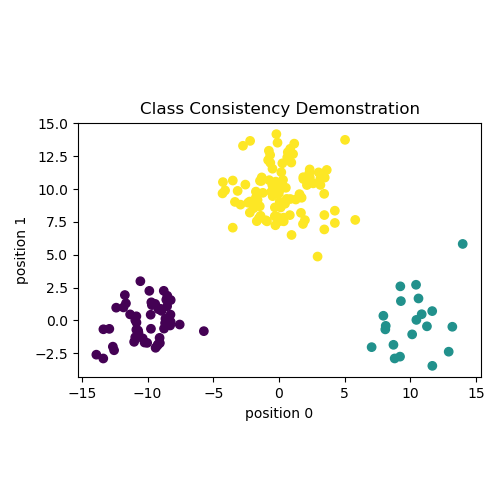

In [2]:
class_consistency_demo()

# Thesis plots

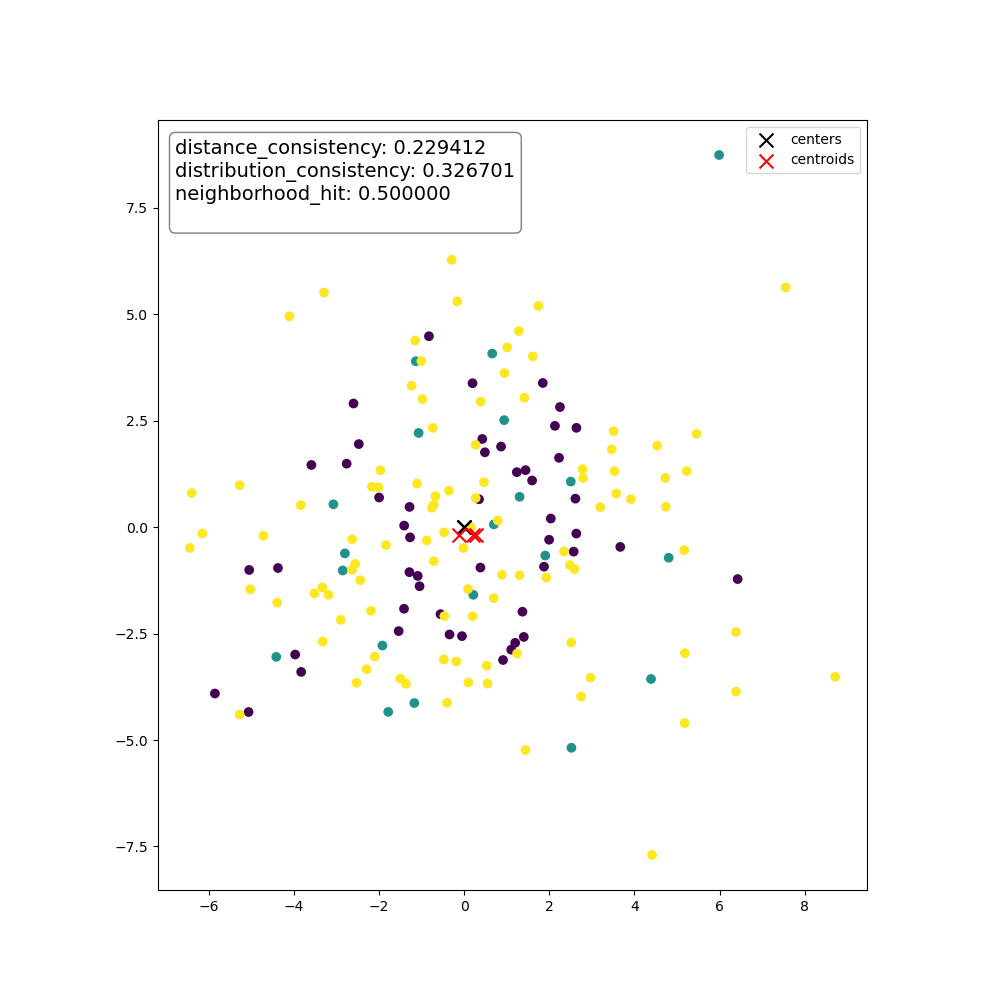

In [44]:
fname = "VCS_c.png"

dims = 2
centers = np.array([[-10,0],[10,0],[0,10]]) #a
centers = np.array([[-15,0],[15,0],[0,15]]) #b
centers = np.zeros((3,dims)) #c
sizes = np.array([50,20,100])

rng = np.random.default_rng(seed=42)

labels = []
positions = np.empty((0,dims))
for i, size in enumerate(sizes):
    positions = np.row_stack((positions, rng.normal(loc=0.0, scale=3.0, size=(size, dims)) + centers[i]))
    labels += size * [i]

labels = np.array(labels)

# compute centroids
centroid_positions = np.array([np.mean(positions[labels == i], axis=0) for i in range(len(sizes))])

# compute metrics
metric = LGC_Metrics(positions, labels)
DSC = metric.metric_distance_consistency() # general implementation
DC = metric.metric_distribution_consistency(k = 7)
total = metric.metric_total(k = 7)
metric_summary = metric.get_summary()
metric_summary = "".join(metric_summary.split("\t")[1:-1])
del metric

# informative plot
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(h=10, w=10)
ax.set_aspect('equal')

ax.scatter(positions[:,0], positions[:,1], c=labels)
ax.scatter(centers[:,0], centers[:,1], marker='x', s=100, c='k', label="centers")
ax.scatter(centroid_positions[:,0], centroid_positions[:,1], marker='x', s=100, c='r', label="centroids")

ax.text(0.025, 0.975, metric_summary, transform=ax.transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', facecolor="white", alpha=0.5))

ax.legend(loc='upper right')

fig.savefig(fname, dpi=fig.dpi, transparent=True, bbox_inches="tight")

plt.show()

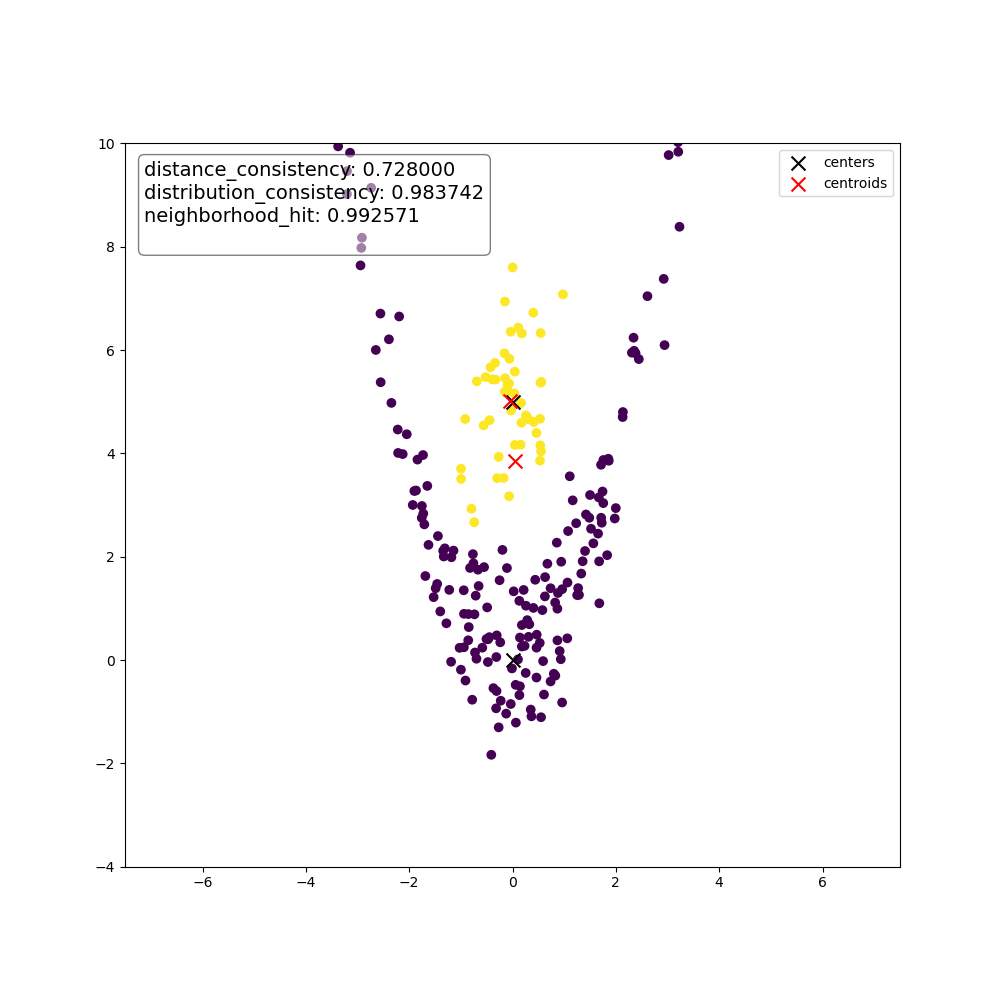

In [40]:
fname = "VCS_d.png"

centers1 = np.array([[0, 0], [0, 5]])

sizes1 = np.array([200, 50])
xscales1 = np.array([2.0, 0.5])
dims = 2

rng = np.random.default_rng(seed=42)

labels1 = []
positions1 = np.empty((0,dims))
for i, size in enumerate(sizes1):
    random_positions = rng.normal(loc=0.0, scale=(xscales1[i], 1.0), size=(size, dims))
    if i == 0:
        random_positions[:,1] = (random_positions[:,0]) ** 2 + random_positions[:,1]
    random_positions += centers1[i]
    positions1 = np.row_stack((positions1, random_positions))
    labels1 += size * [i]

labels1 = np.array(labels1)

# compute centroids
centroid_positions1 = np.array([np.mean(positions1[labels1 == i], axis=0) for i in range(len(sizes1))])

metric = LGC_Metrics(positions1, labels1)
DSC = metric.metric_distance_consistency() # general implementation
DC = metric.metric_distribution_consistency(k = 7)
total = metric.metric_total(k = 7)
metric_summary = metric.get_summary()
metric_summary = "".join(metric_summary.split("\t")[1:-1])
del metric

# some informative plots
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(h=10, w=10)
ax.set_aspect('equal')

ax.scatter(positions1[:,0], positions1[:,1], c=labels1)
ax.scatter(centers1[:,0], centers1[:,1], marker='x', s=100, c='k', label="centers")
ax.scatter(centroid_positions1[:,0], centroid_positions1[:,1], marker='x', s=100, c='r', label="centroids")

ax.text(0.025, 0.975, metric_summary, transform=ax.transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', facecolor="white", alpha=0.5))

ax.set_xlim((-7.5,7.5))
ax.set_ylim((-4,10))

ax.legend(loc="upper right")

fig.savefig(fname, dpi=fig.dpi, transparent=True, bbox_inches="tight")

plt.show()